In [1]:
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib_venn as pltv
import matplotlib.pyplot as plt

In [2]:
from ProjectTools import OpenBeds

dry = False

def dropColumns(df):
    redundant_columns = ["modification_type", "percentMeth", "strand", "modified_reads", "unmodified_reads"]
    return df.drop(columns=redundant_columns, errors="ignore")    

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_2mod = dropColumns(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = dropColumns(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = dropColumns(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = dropColumns(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))
    
    nano_mc_df, nano_hmc_df = map(dropColumns, [nano_mc_df, nano_hmc_df])

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_2mod = dropColumns(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = dropColumns(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = dropColumns(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = dropColumns(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

    nano_mc_df, nano_hmc_df = map(dropColumns, [nano_mc_df, nano_hmc_df])

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

def filterMergeNano(nano_mc, nano_hmc):
    filtered_mc = filterDepth(nano_mc).drop(columns="method")
    filtered_hmc = filterDepth(nano_hmc).drop(columns="method")
    
    on_list = ["chromosome", "chromStart", "chromEnd"]
    merged = pd.merge(filtered_mc, filtered_hmc, "inner", on_list, suffixes=["_5mC", "_5hmC"])

    merged["method"] = "Nanopore"
    merged["readCount"] = merged[["readCount_5mC", "readCount_5hmC"]].mean(axis=1)
    
    return merged.drop(columns=["readCount_5mC", "readCount_5hmC"])

def easyMerge(l, r):
    return pd.merge(l, r, "inner", ["chromosome", "chromStart", "chromEnd"])

def makeUniqueSet(df):
    return set(df["chromosome"].map(str) + df["chromStart"].map(str))

In [3]:
nano_2mod_set = makeUniqueSet(nano_2mod)
wgbs_set = makeUniqueSet(wgbs_df)

two_mod_venn = {
    "nano" : len(nano_2mod_set.difference(wgbs_set)),
    "wgbs" : len(wgbs_set.difference(nano_2mod_set)),
    "intersect" : len(nano_2mod_set.intersection(wgbs_set))
} 

tab_set = makeUniqueSet(tab_df)
oxbs_set = makeUniqueSet(oxbs_df)
nano_3mod_set = makeUniqueSet(pd.merge(nano_hmc_df, nano_mc_df, "outer", ["chromosome", "chromStart", "chromEnd"]))

three_mod_venn = {
    "intersect" : len(nano_3mod_set.intersection(oxbs_set, tab_set)),
    "nano" : len(nano_3mod_set.difference(tab_set, oxbs_set)),
    "tab" : len(tab_set.difference(nano_3mod_set, oxbs_set)),
    "oxbs" : len(oxbs_set.difference(nano_3mod_set, tab_set)),
    "nano&TAB" : len(nano_3mod_set.intersection(tab_set).difference(oxbs_set)), 
    "nano&oxBS" : len(nano_3mod_set.intersection(oxbs_set).difference(tab_set)), 
    "TAB&oxBS" : len(tab_set.intersection(oxbs_set).difference(nano_3mod_set))
}

In [4]:
from pybedtools import BedTool

def findTypeIntersects(mod_bed, ref_features_bed, intergenic_bed):
    features_df = BedTool.intersect(mod_bed, ref_features_bed, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "readCount", "method", "dup1", "dup2", "dup3", "feature_type"])
    features_df.loc[features_df["feature_type"].str.contains("CpG"), "feature_type"] = "CGI"
    intergenic_df = BedTool.intersect(mod_bed, intergenic_bed, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd",  "readCount", "method", "dup1", "dup2", "dup3", "feature_type"])

    return pd.concat([features_df, intergenic_df]).reset_index(drop=True).drop(columns=["dup1", "dup2", "dup3"])

In [5]:

ref_features = BedTool('./feature_references/fig1_features.bed')
intergenic_bed = BedTool('./feature_references/fig1_features/mm39_intergenic_noID.bed')

def generateModbed(mod_df1, mod_df2, mod_df3=None):
    filtered_df1 = filterDepth(mod_df1)
    filtered_df2 = filterDepth(mod_df2)
    
    if mod_df3 is not None: 
        filtered_df3 = filterDepth(mod_df3)
        concat_dfs = pd.concat([filtered_df1, filtered_df2, filtered_df3])
    else: 
        concat_dfs = pd.concat([filtered_df1, filtered_df2])

    concat_dfs.loc[concat_dfs["method"].str.contains("Nanopore"), "method"] = "Nanopore"
    return BedTool.from_dataframe(concat_dfs)

def generateGenomewide(mod_df):
    dummy_df = mod_df.copy()
    dummy_df["feature_type"] = "Genome-wide"

    dummy_df.loc[dummy_df["method"].str.contains("Nanopore"), "method"] = "Nanopore"
    return dummy_df

def includeGenomewide(intersects_df, mod_df1, mod_df2, mod_df3=None):
    if mod_df3 is not None:
        return pd.concat([intersects_df, generateGenomewide(mod_df1), generateGenomewide(mod_df2), generateGenomewide(mod_df3)]).reset_index(drop=True)
    else:
        return pd.concat([intersects_df, generateGenomewide(mod_df1), generateGenomewide(mod_df2)]).reset_index(drop=True)
        
def calculateFilteredGenomeMedian(mod_df):
    return filterDepth(mod_df)["readCount"].median()

In [6]:
two_mod_feature_df = includeGenomewide(
    findTypeIntersects(
        generateModbed(nano_mc_df, wgbs_df), 
        ref_features, intergenic_bed),
    filterDepth(nano_mc_df), 
    filterDepth(wgbs_df))

three_mod_feature_df = includeGenomewide(
    findTypeIntersects(
        generateModbed(nano_hmc_df, tab_df, oxbs_df), 
        ref_features, intergenic_bed),
    filterDepth(nano_hmc_df), 
    filterDepth(tab_df),
    filterDepth(oxbs_df))

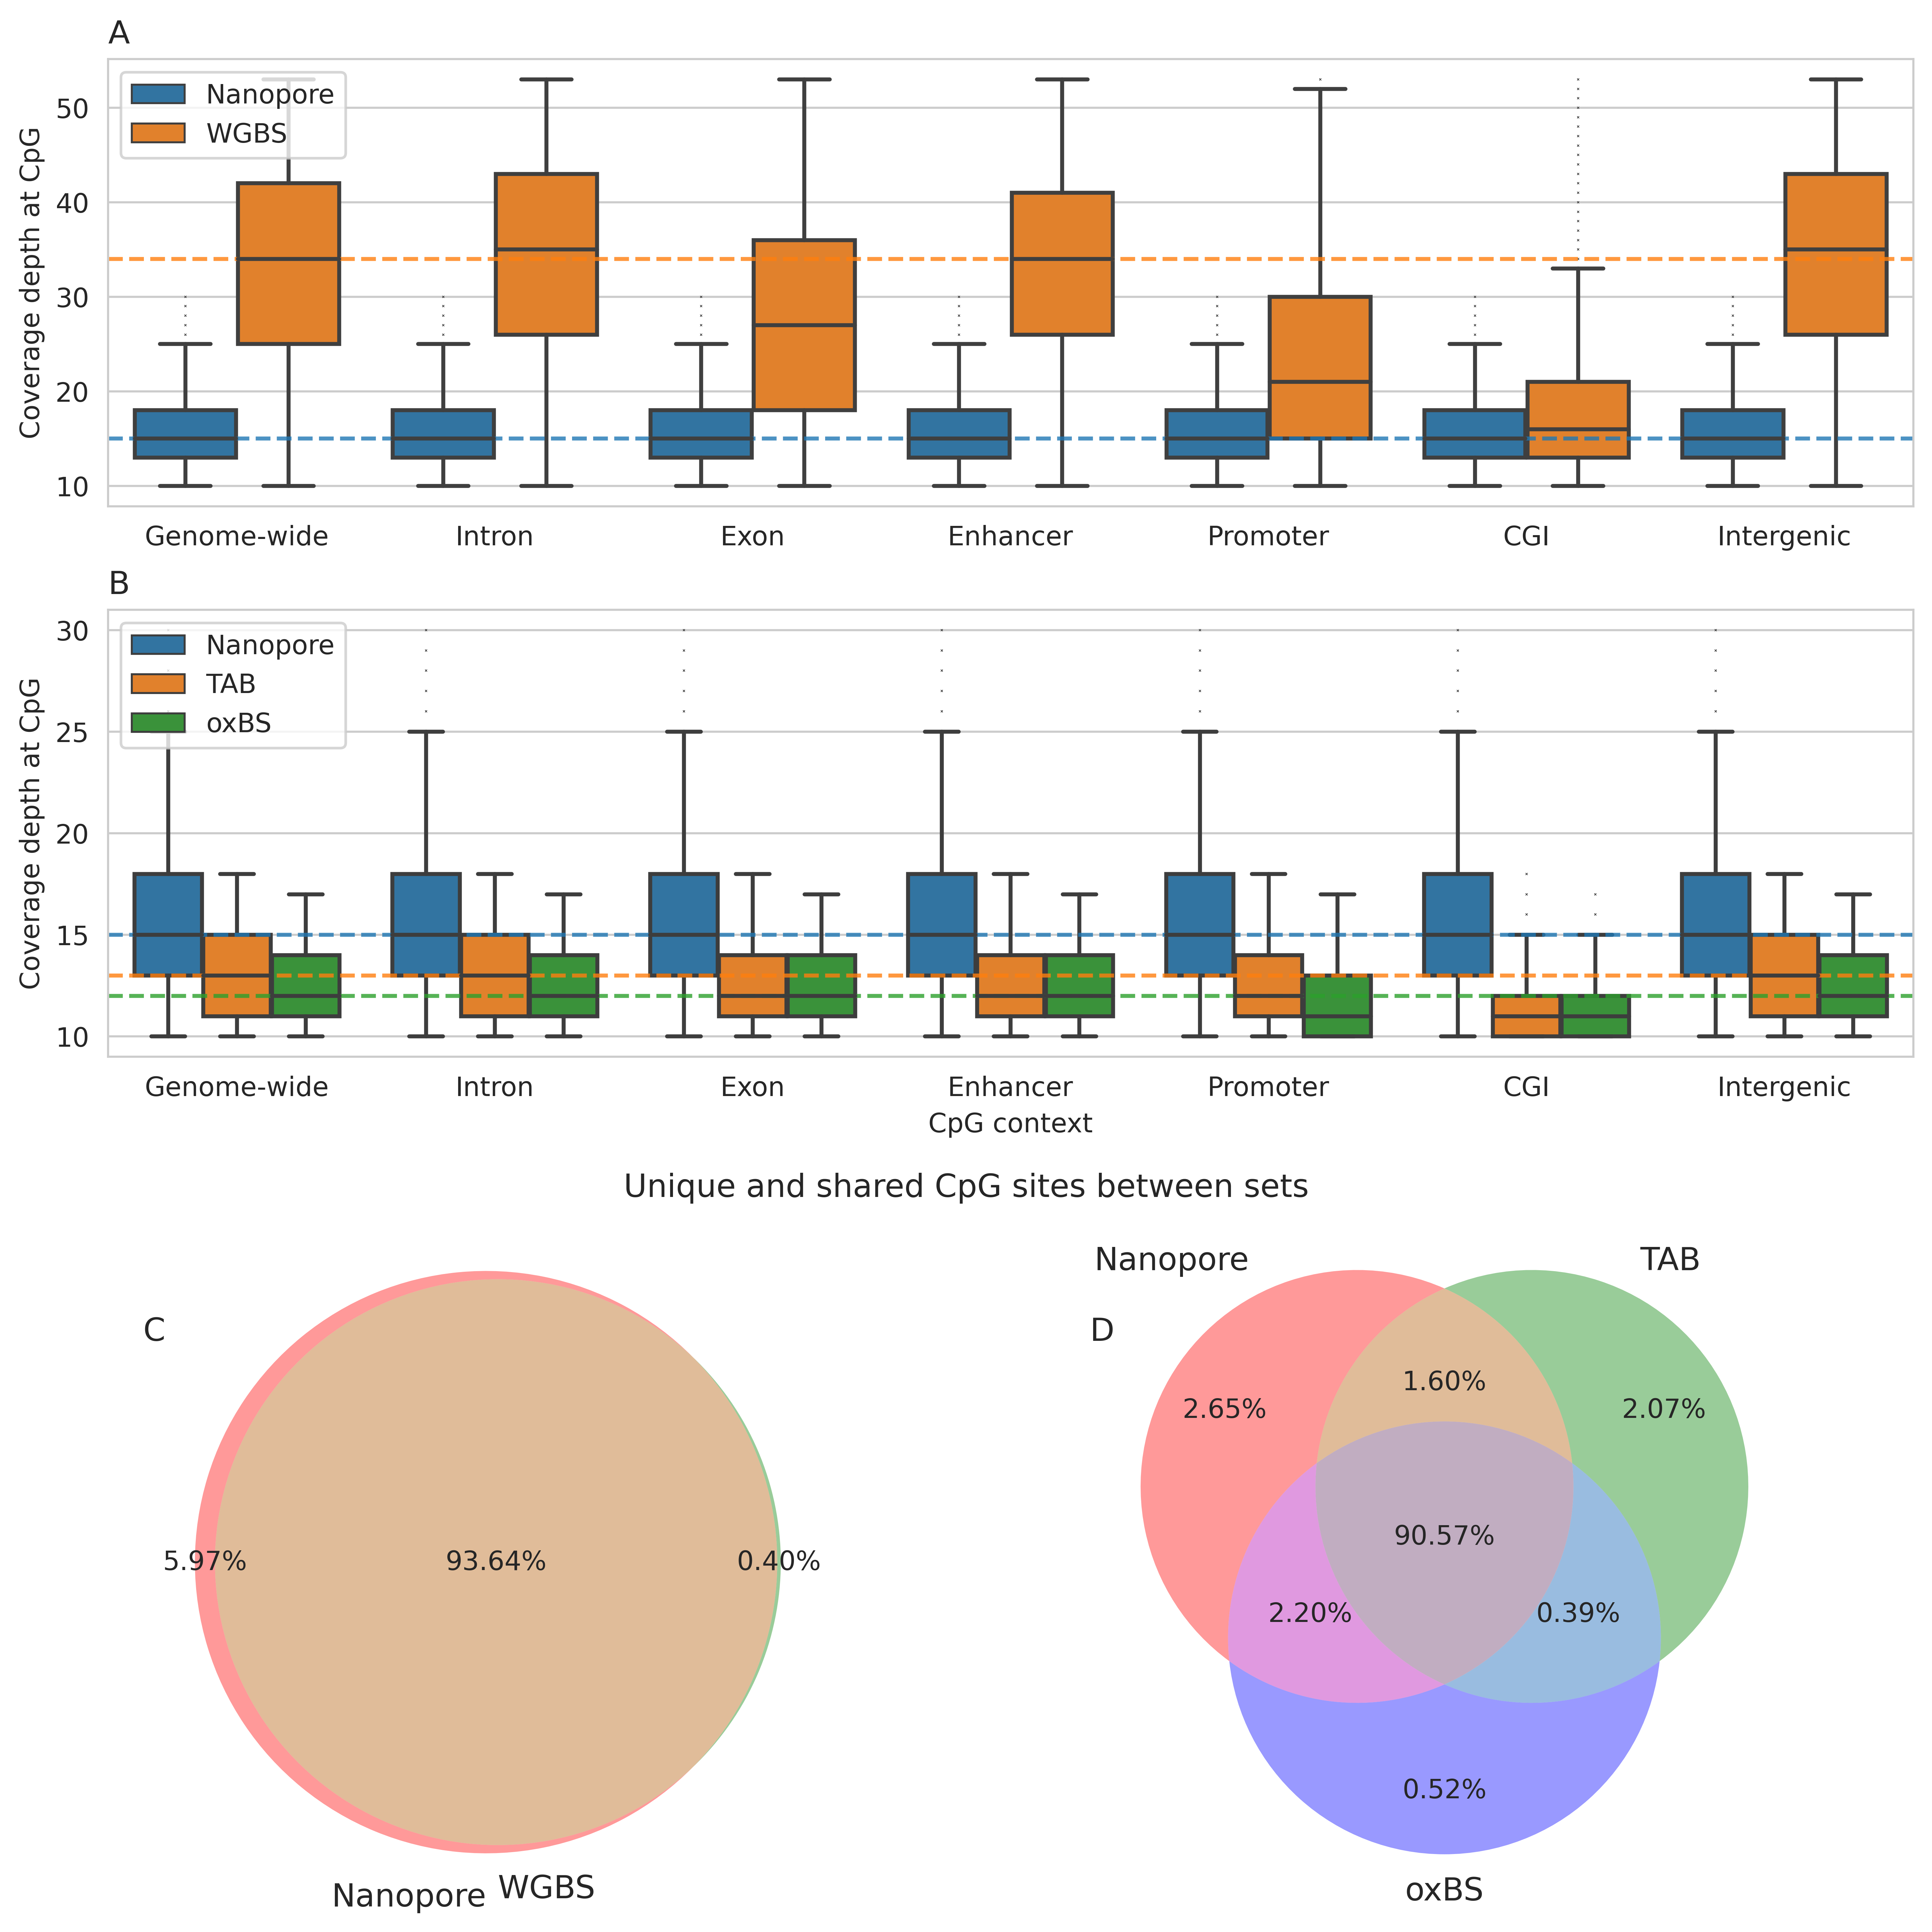

In [7]:
import matplotlib.gridspec as gridspec

sns.set_style("whitegrid")
sns.set_palette("tab10")

fig0 = plt.figure(figsize=(10,10), dpi=600)
gs0 = gridspec.GridSpec(2, 1, fig0, height_ratios=[3,2])

fig1 = fig0.add_subfigure(gs0[0, :])
gs1 = gridspec.GridSpec(2, 1, fig1)

ax1 = fig1.add_subplot(gs1[0, :])
sns.boxplot(two_mod_feature_df, x="feature_type", y="readCount", hue="method", ax=ax1,
    order=["Genome-wide", "Intron", "Exon", "Enhancer", "Promoter", "CGI", "Intergenic"], 
    flierprops={
    "marker":"x", 
    "markersize" : 0.1
    }
    )
sns.move_legend(ax1, "upper left", title=None)
ax1.tick_params("x")
ax1.set(xlabel=None, ylabel="Coverage depth at CpG")
ax1.set_title("A", loc="left")
ax1.axhline(y=calculateFilteredGenomeMedian(nano_mc_df), alpha=0.8, color=sns.color_palette("tab10", 2)[0], linestyle="--")
ax1.axhline(y=calculateFilteredGenomeMedian(wgbs_df), alpha=0.8, color=sns.color_palette("tab10", 2)[1], linestyle="--")

ax2 = fig1.add_subplot(gs1[1, :], sharex=ax1)
sns.boxplot(three_mod_feature_df, x="feature_type", y="readCount", hue="method", ax=ax2,
        order=["Genome-wide", "Intron", "Exon", "Enhancer", "Promoter", "CGI", "Intergenic"],
        flierprops={
        "marker":"x", 
        "markersize" : 0.1
        }
        )
sns.move_legend(ax2, "upper left", title=None)
ax2.set(xlabel="CpG context", ylabel="Coverage depth at CpG")
ax2.tick_params("x")
ax2.set_title("B", loc="left")
ax2.axhline(y=calculateFilteredGenomeMedian(nano_hmc_df), alpha=0.8, color=sns.color_palette("tab10", 3)[0], linestyle="--")
ax2.axhline(y=calculateFilteredGenomeMedian(tab_df), alpha=0.8, color=sns.color_palette("tab10", 3)[1], linestyle="--")
ax2.axhline(y=calculateFilteredGenomeMedian(oxbs_df), alpha=0.8, color=sns.color_palette("tab10", 3)[2], linestyle="--")

fig2 = fig0.add_subfigure(gs0[1,:])
gs2 = gridspec.GridSpec(1, 2, fig2)

ax3 = fig2.add_subplot(gs2[0, 0])
pltv.venn2([nano_2mod_set, wgbs_set], set_labels=["Nanopore", "WGBS"], 
            subset_label_formatter=lambda x: f"{(x/len(nano_2mod_set.union(wgbs_set))):.2%}", 
            ax=ax3)
ax3.set_title("C", loc="left", y=0.8)

ax4 = fig2.add_subplot(gs2[0, 1])
pltv.venn3_unweighted([nano_3mod_set, tab_set, oxbs_set], set_labels=["Nanopore", "TAB", "oxBS"], 
                      subset_label_formatter=lambda x: f"{(x/len(nano_3mod_set.union(tab_set, oxbs_set))):.2%}",
                      ax=ax4)
ax4.set_title("D", loc="left", y=0.8)
fig2.suptitle("Unique and shared CpG sites between sets")

fig0.set_constrained_layout(True)
fig0.show()

In [8]:
filterDepth(nano_mc_df)["readCount"].median(), filterDepth(nano_hmc_df)["readCount"].median(), filterDepth(wgbs_df)["readCount"].median(), filterDepth(oxbs_df)["readCount"].median(), filterDepth(tab_df)["readCount"].median()

(15.0, 15.0, 34.0, 12.0, 13.0)